In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle

# Loading Data
file_path = "C:\\Users\\ARUN ROSHAN\\patient-care-analysis\\datasets\\modified_dataset (1).csv"
data = pd.read_csv(file_path)

# Creating the Graph
G_subset = nx.Graph()
for _, row in data.iterrows():
    patient_id = f"Patient{row['PatientID']}"
    G_subset.add_node(patient_id, type='Patient')
    disease = row['Disease']
    G_subset.add_node(disease, type='Disease')
    G_subset.add_edge(patient_id, disease, type='SuffersFrom')

    symptoms = row['Symptoms'].split(',')
    for symptom in symptoms:
        symptom = symptom.strip()
        G_subset.add_node(symptom, type='Symptom')
        G_subset.add_edge(patient_id, symptom, type='HasSymptom')
        G_subset.add_edge(disease, symptom, type='AssociatedWith')

# Feature Extraction
def extract_features(symptoms, graph):
    features = []
    for symptom in symptoms:
        if symptom in graph:
            disease_neighbors = [n for n in graph.neighbors(symptom) if graph.nodes[n]['type'] == 'Disease']
            features.append(len(disease_neighbors))
        else:
            features.append(0)
    return features



In [3]:
# Preparing Data
X = []
y = []
for _, row in data.iterrows():
    symptoms = [s.strip() for s in row['Symptoms'].split(',')]
    features = extract_features(symptoms, G_subset)
    X.append(features)
    y.append(row['Disease'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
df_X = pd.DataFrame(X).fillna(0)

vectorizer = CountVectorizer()
X_symptoms = vectorizer.fit_transform(data['Symptoms'])

X_combined = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(X_symptoms.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)

X_combined.columns = X_combined.columns.astype(str)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# Pipeline with SMOTE
smote = SMOTE(random_state=42)
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.1],
    'clf__max_depth': [3, 5]
}



In [7]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)
randomized_search.fit(X_train, y_train)


c:\Users\ARUN ROSHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('clf',
                                              GradientBoostingClassifier(random_state=42))]),
                   param_distributions={'clf__learning_rate': [0.1],
                                        'clf__max_depth': [3, 5],
                                        'clf__n_estimators': [100, 200]},
                   random_state=42, scoring='accuracy')

In [8]:
best_model = randomized_search.best_estimator_

# Evaluation
accuracy = best_model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.95


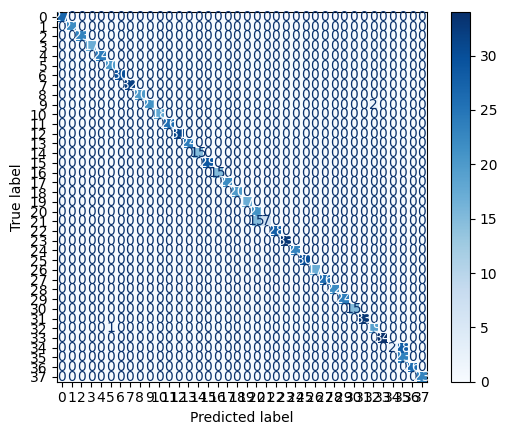

In [9]:
y_pred = best_model.predict(X_test)
unique_labels = sorted(set(y_test) | set(y_pred))

cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [10]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = report_dict['accuracy']
macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Average - Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-Score: {macro_avg['f1-score']:.2f}")
print(f"Weighted Average - Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-Score: {weighted_avg['f1-score']:.2f}")

# Save Model Components
model_components = {
    'model': best_model,
    'vectorizer': vectorizer,
    'label_encoder': label_encoder
}

Accuracy: 0.95
Macro Average - Precision: 0.97, Recall: 0.95, F1-Score: 0.94
Weighted Average - Precision: 0.97, Recall: 0.95, F1-Score: 0.94


In [12]:
model_file_path = "model_components_gbm.pkl"  # Corrected the variable name
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model_components, model_file)


In [13]:
def predict_disease(symptoms):
    features = extract_features(symptoms.split(','), G_subset)
    features_df = pd.DataFrame([features]).fillna(0)
    features_vectorized = vectorizer.transform([', '.join(symptoms.split(','))]).toarray()
    features_vectorized_df = pd.DataFrame(features_vectorized, columns=vectorizer.get_feature_names_out())

    combined_features = pd.concat([features_df.reset_index(drop=True), features_vectorized_df], axis=1).reindex(columns=X_combined.columns, fill_value=0)

    disease_probs = best_model.predict_proba(combined_features)[0]
    top_3_indices = disease_probs.argsort()[-3:][::-1]
    top_3_diseases = label_encoder.inverse_transform(top_3_indices)

    top_disease = top_3_diseases[0]
    disease_info = data[data['Disease'] == top_disease].iloc[0]
    description = disease_info['Description']
    precautions = disease_info['Precautions']
    medications = disease_info['Medications']
    diet = disease_info['Diet']
    workout = disease_info['Workout']

    return top_3_diseases, description, precautions, medications, diet, workout

In [14]:
# Example Prediction
symptoms_input = "fever, cough, headache"
top_diseases, description, precautions, medications, diet, workout = predict_disease(symptoms_input)
print(f"Top 3 Predicted Diseases: {top_diseases}")
print(f"Details for {top_diseases[0]}: \nDescription: {description}\nPrecautions: {precautions}\nMedications: {medications}\nDiet: {diet}\nWorkout: {workout}")

Top 3 Predicted Diseases: ['Bronchial Asthma' 'Common Cold' 'Malaria']
Details for Bronchial Asthma: 
Description: Bronchial Asthma is a respiratory condition characterized by inflammation of the airways.
Precautions: switch to loose cloothing, take deep breaths, get away from trigger, seek help
Medications: Bronchodilators, Inhaled corticosteroids, Leukotriene modifiers, Mast cell stabilizers, Anticholinergics
Diet: Anti-Inflammatory Diet, Omega-3-rich foods, Fruits and vegetables, Whole grains, Lean proteins
Workout: Include anti-inflammatory foods, Consume omega-3 fatty acids, Limit sodium intake, Stay hydrated, Include antioxidant-rich foods, Avoid sulfite-containing foods, Limit processed foods, Consume magnesium-rich foods, Consult a healthcare professional, Avoid trigger foods
